# Memory-efficient SAGA

In [2]:
import pyximport; pyximport.install()
# import saga_authors

import numpy as np
import scipy.sparse as sparse
import sklearn.linear_model, sklearn.metrics
import matplotlib.pyplot as plt
import time

%matplotlib inline

## Data

Problem: Prediction of the release year of a song from audio features. Songs are mostly western, commercial tracks ranging from 1922 to 2011, with a peak in the year 2000s.

* Dataset can be downloaded at https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD.
* 90 audio attributes: 12 = timbre average, 78 = timbre covariance
    * Features extracted from the 'timbre' features from The Echo Nest API. We take the average and covariance over all 'segments', each segment being described by a 12-dimensional timbre vector.
* The first value is the year (target), ranging from 1922 to 2011. 
* train: first 463,715 examples, test: last 51,630 examples
    * It avoids the 'producer effect' by making sure no song from a given artist ends up in both the train and test set.

In [3]:
data = np.loadtxt('YearPredictionMSD.txt', delimiter=',')

In [4]:
# Song release year.
train_target = data[:463715,0]  #.astype(np.int32)
test_target  = data[463715:,0]  #.astype(np.int32)
assert test_target.shape == (51630,)

# Audio features.
train_data = data[:463715,1:]
test_data  = data[463715:,1:]
assert train_data.shape == (463715,90)
assert test_data.shape == (51630,90)

# Subset for fast testing purpose.
#n = 10000
#train_data = data[:n,1:]
#train_target = data[:n,0]

# Normalize so as to do not need an intercept.
intercept = train_target.mean()
data_mean = train_data.mean(axis=0)
train_target = train_target - intercept
test_target = test_target - intercept
train_data = train_data - data_mean
test_data = test_data - data_mean

## Linear regression: ground truth

* Sanity check of the performance of a linear classifier.
* Exact least-square solution to compare with SAGA.

R^2 score on train set: 0.2375
R^2 score on test set: 0.2320


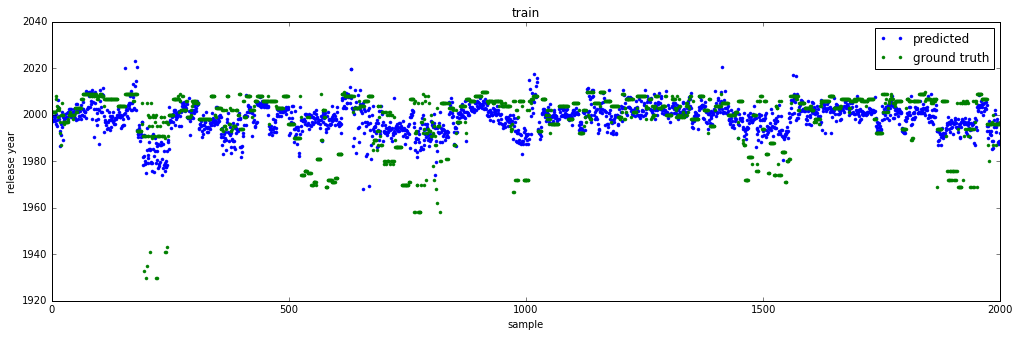

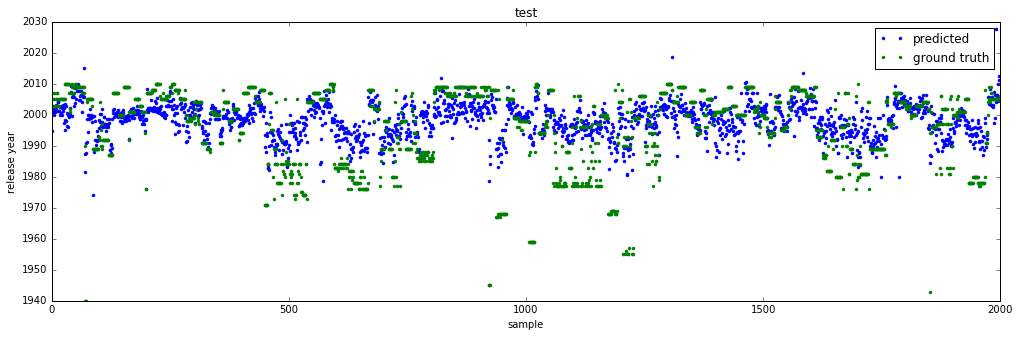

In [5]:
x_natural = np.linalg.lstsq(train_data, train_target)[0]

cls = sklearn.linear_model.LinearRegression(fit_intercept=True)
cls.fit(train_data, train_target)
assert cls.intercept_ < 1e-10
np.testing.assert_allclose(cls.coef_, x_natural)

def score(x, dataset, plot=2000):
    A = eval('{}_data'.format(dataset))
    y = eval('{}_target'.format(dataset)) + intercept
    pred = A.dot(x) + intercept
    score = sklearn.metrics.r2_score(y, pred)
    print('R^2 score on {} set: {:.4f}'.format(dataset, score))
    
    if plot > 0:
        plt.figure(figsize=(17,5))
        plt.plot(pred[:plot], '.', label='predicted')
        plt.plot(y[:plot], '.', label='ground truth')
        plt.title(dataset)
        plt.xlabel('sample')
        plt.ylabel('release year')
        plt.legend()
score(x_natural, 'train')
score(x_natural, 'test')

## SAGA

* Cython code from the authors.
    * To solve least-square problems only.
    * It uses the tricks from Section 4 of the paper.
* Minimal and straightforward implementation by us.
    * It provides the same results and is only 3 times slower.

In [ ]:
def saga_lstsq_authors(A, y, maxiter, gamma, reg=0):
    """
    Solve min_x ||Ax - b||_2^2 reg*||x||_2^2
    
    Parameters:
        gamma: step size or learning rate
        reg:   amount of L2 regularization
    """
    tstart = time.process_time()
    
    # Proper data type.
    A = sparse.csc_matrix(A.T)
    A.indices = A.indices.astype(np.int64)
    A.indptr = A.indptr.astype(np.int64)
    y = y.astype(np.float64)
    
    # Algorithm (eta is the inverse step size).
    props = {'eta': 1 / gamma, 'reg': reg}
    x = saga_authors.saga_lstsq(A, y, maxiter, props)
    
    print('Elapsed time: {:.2f}s'.format(time.process_time() - tstart))
    return x

In [6]:
def saga(A, y, gradf, prox, maxiter, gamma):
    n, d = A.shape  # number of observations x dimensionality
    x = np.zeros(d)
    grads = np.array([gradf(x,i) for i in range(n)])
    avg = grads.mean(axis=0)
    X = np.empty((maxiter, d))
    
    for epoch in range(maxiter):
        #indices = np.random.permutation(n)
        indices = np.random.randint(0, n, n)
        
        for i in indices:
            grad = gradf(x,i)
            x = x - gamma * (grad - grads[i,:] + avg)
            x = prox(x, gamma)
            avg += (grad - grads[i,:]) / n
            grads[i,:] = grad
            
        X[epoch,:] = x
        
    return X

def saga_lstsq(A, y, maxiter, gamma, reg=0, x_natural=None):
    tstart = time.process_time()
    
    gradf = lambda x, i: A[i,:].T.dot(A[i,:].dot(x) - y[i])
    prox  = lambda x, gamma: x
    
    X = saga(A, y, gradf, prox, maxiter, gamma)
    print('Elapsed time: {:.2f}s'.format(time.process_time() - tstart))
    return X

In [7]:
def plot_convergence(A, y, X, x_natural):
    f = lambda x: np.sum((A.dot(x) - y)**2) / 2
    maxiter = X.shape[0]
    objective = np.array([f(X[i,:]) for i in range(maxiter)])
    objective -= f(x_natural)
    
    plt.figure(figsize=(17,5))
    plt.semilogy(np.arange(maxiter)+1, objective)
    plt.xlim(1, maxiter)
    plt.title('convergence')
    plt.xlabel('epoch')
    plt.ylabel('function sub-optimality')

Elapsed time: 0.44s


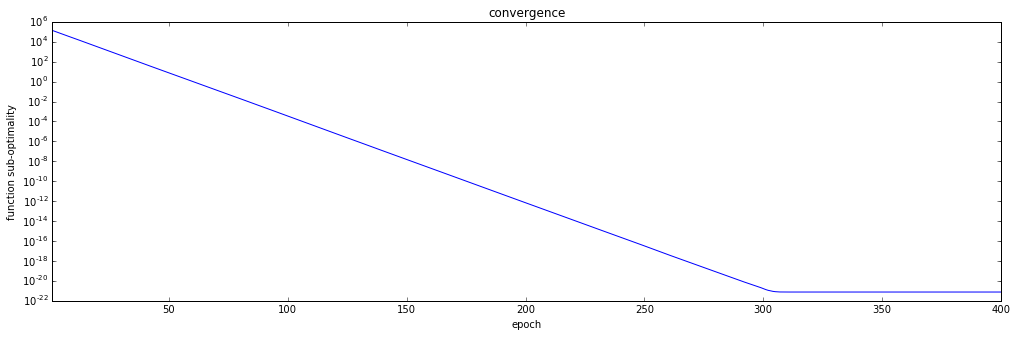

In [9]:
n = 100
A = np.identity(n)
y = np.arange(n)

# x = saga_lstsq_authors(A, y, maxiter=400, gamma=0.1, reg=0)
# np.testing.assert_allclose(x, y)

X = saga_lstsq(A, y, maxiter=400, gamma=0.1, reg=0)
np.testing.assert_allclose(X[-1,:], y)
plot_convergence(A, y, X, y)

## Linear regression: SAGA

Elapsed time: 44.66s
R^2 score on train set: 0.1498
R^2 score on test set: 0.1475


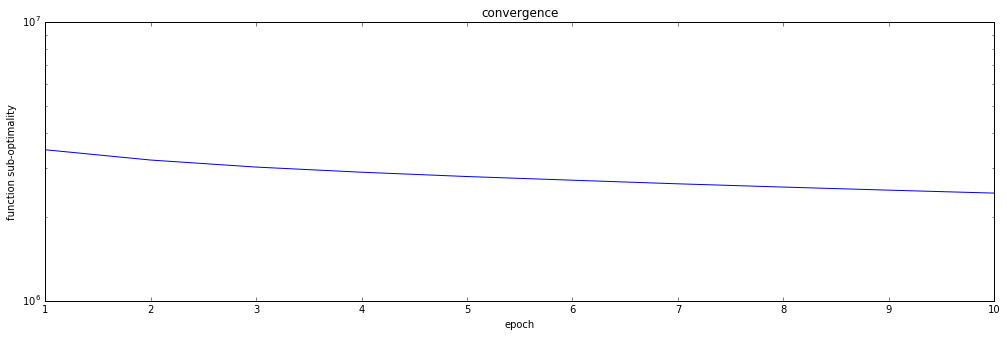

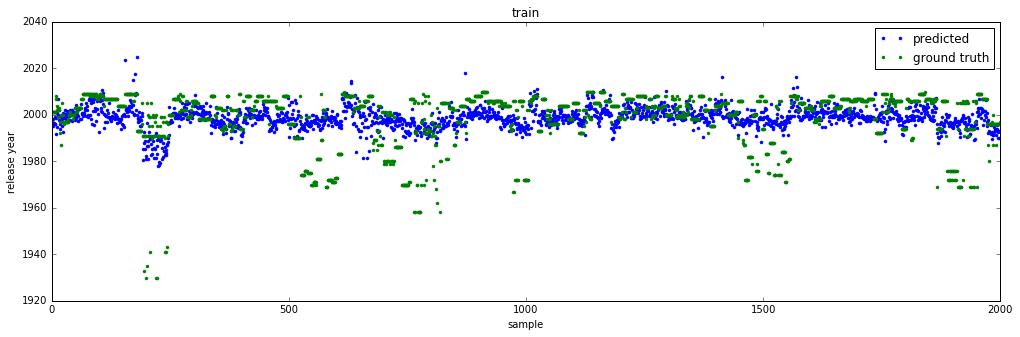

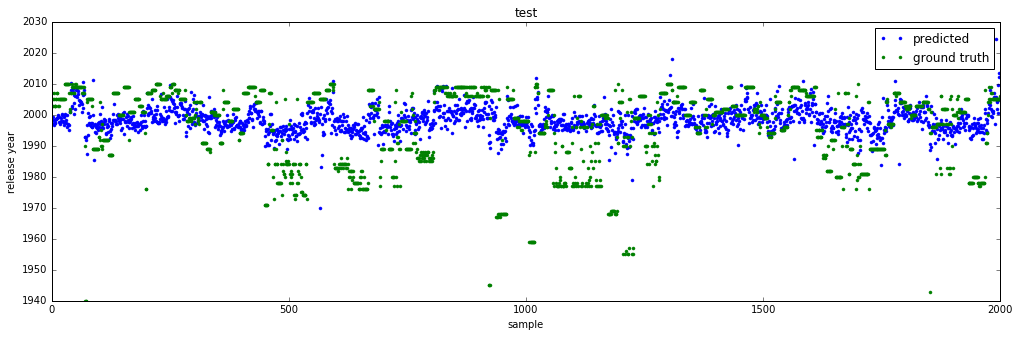

In [11]:
params = {'maxiter': 10, 'gamma': 1e-9, 'reg': 0}

# x = saga_lstsq_authors(train_data, train_target, **params)
# score(x, 'train', plot=0)
# score(x, 'test', plot=0)

X = saga_lstsq(train_data, train_target, **params)
plot_convergence(train_data, train_target, X, x_natural)
score(X[-1,:], 'train')
score(X[-1,:], 'test')